### [2025_12_08]_과제
- 다양한 생선의 품종 식별 모델
- 데이터 : fish.csv
- 데이터 증강 : 160행 => (생선품종별로 갯수 동일하게 맞추기)
                     10K행
- 필수
   * 전처리
   * 타겟과 관련성 높은 피쳐 선택
   * 모델: KNN
   * 교차 검증 진행
   * 예측에 따른 확인 작업 필수

[1] 모듈 로딩 및 데이터 준비 <hr>

In [50]:
## 모듈 로딩
#-> 기본 모듈
import numpy as np
import pandas as pd

#-> 시각화 모듈
import matplotlib.pyplot as plt
import koreanize_matplotlib

#-> ML 관련 모듈
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [51]:
## 훈련 데이터 준비
DATA_FILE = '../Data/fish_train_10500.csv'

df = pd.read_csv(DATA_FILE)
df.Species.unique()

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

In [52]:
df.Species.value_counts()

Species
Bream        1500
Roach        1500
Whitefish    1500
Parkki       1500
Perch        1500
Pike         1500
Smelt        1500
Name: count, dtype: int64

In [53]:
df.head()

,Weight,Length,Diagonal,Height,Width,Species
0,487.423341,32.423746,37.857082,14.591014,5.270922,Bream
1,990.896538,41.365270,47.308866,18.719116,7.000605,Bream
2,627.081718,33.444702,38.939902,15.463397,5.670238,Bream
3,749.382720,35.686411,41.026632,15.974293,6.036774,Bream
4,615.621949,33.527752,39.005218,15.502285,5.483102,Bream


[2] 데이터 전처리 및 학습 준비 <hr>

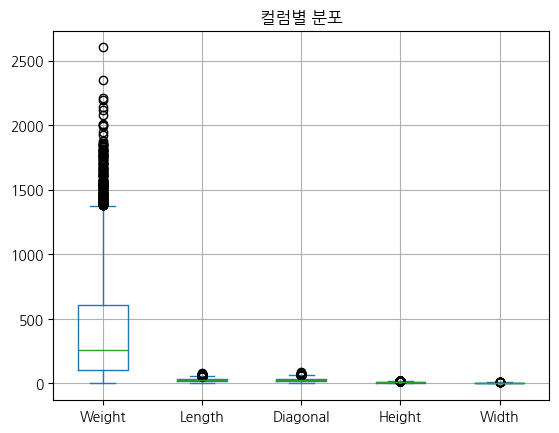

In [54]:
## -----------------------------------------
## 결측치/중복값/이상치
## -----------------------------------------
df.isna().sum()         ## => 0개

df.duplicated().sum()   ## => 0개

df.plot(kind='box', title='컬럼별 분포', grid=True)
plt.show()

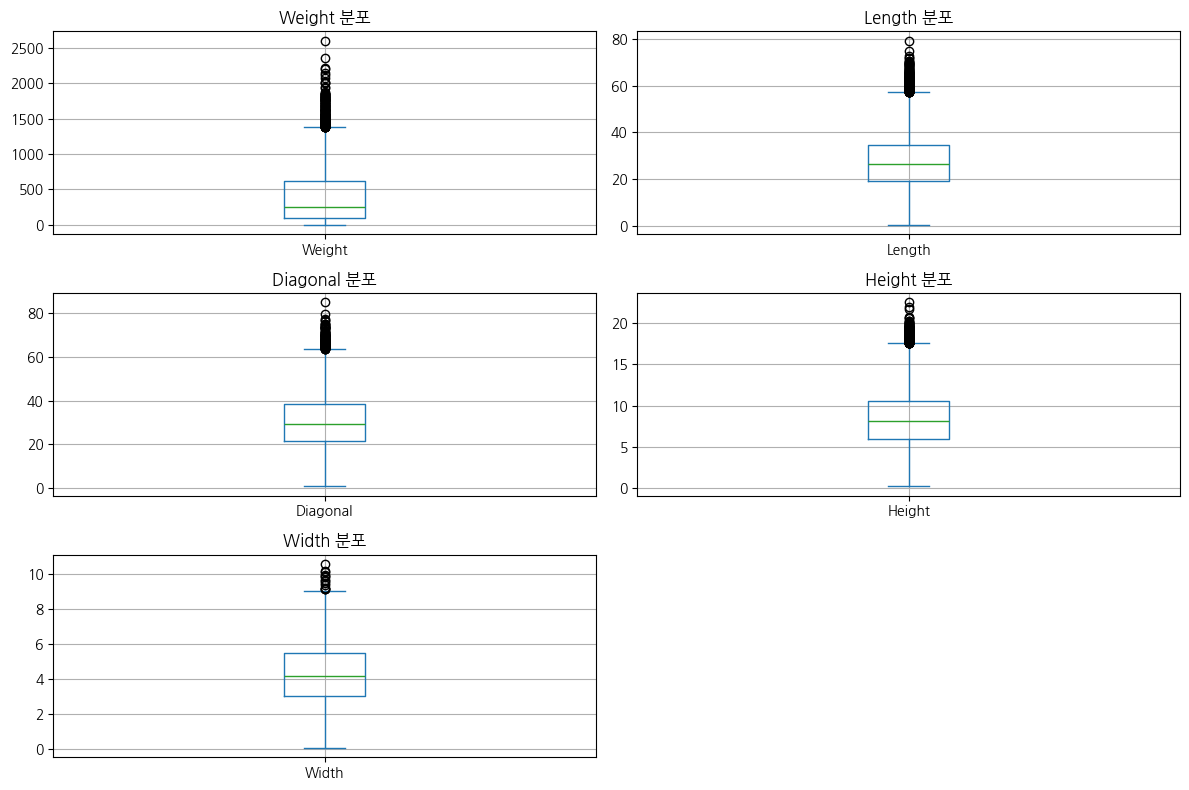

In [55]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

df[['Weight']].plot(kind='box', ax=axes[0, 0], grid=True)
axes[0, 0].set_title('Weight 분포')

df[['Length']].plot(kind='box', ax=axes[0, 1], grid=True)
axes[0, 1].set_title('Length 분포')

df[['Diagonal']].plot(kind='box', ax=axes[1, 0], grid=True)
axes[1, 0].set_title('Diagonal 분포')

df[['Height']].plot(kind='box', ax=axes[1, 1], grid=True)
axes[1, 1].set_title('Height 분포')

df[['Width']].plot(kind='box', ax=axes[2, 0], grid=True)
axes[2, 0].set_title('Width 분포')

axes[2, 1].set_visible(False)  # 마지막 칸 비우기

plt.tight_layout()
plt.show()

In [ ]:
## 이상치 제거 함수 만들기
def delete_iqr_df(df, col):
    s = df[col]
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1

    cond = (s >= q1 - 1.5*iqr) & (s <= q3 + 1.5*iqr)
    return df[cond]

In [57]:
# 모든 열 이상치 제거하기
for col in ['Weight', 'Length', 'Diagonal', 'Height', 'Width']:
    df = delete_iqr_df(df, col)

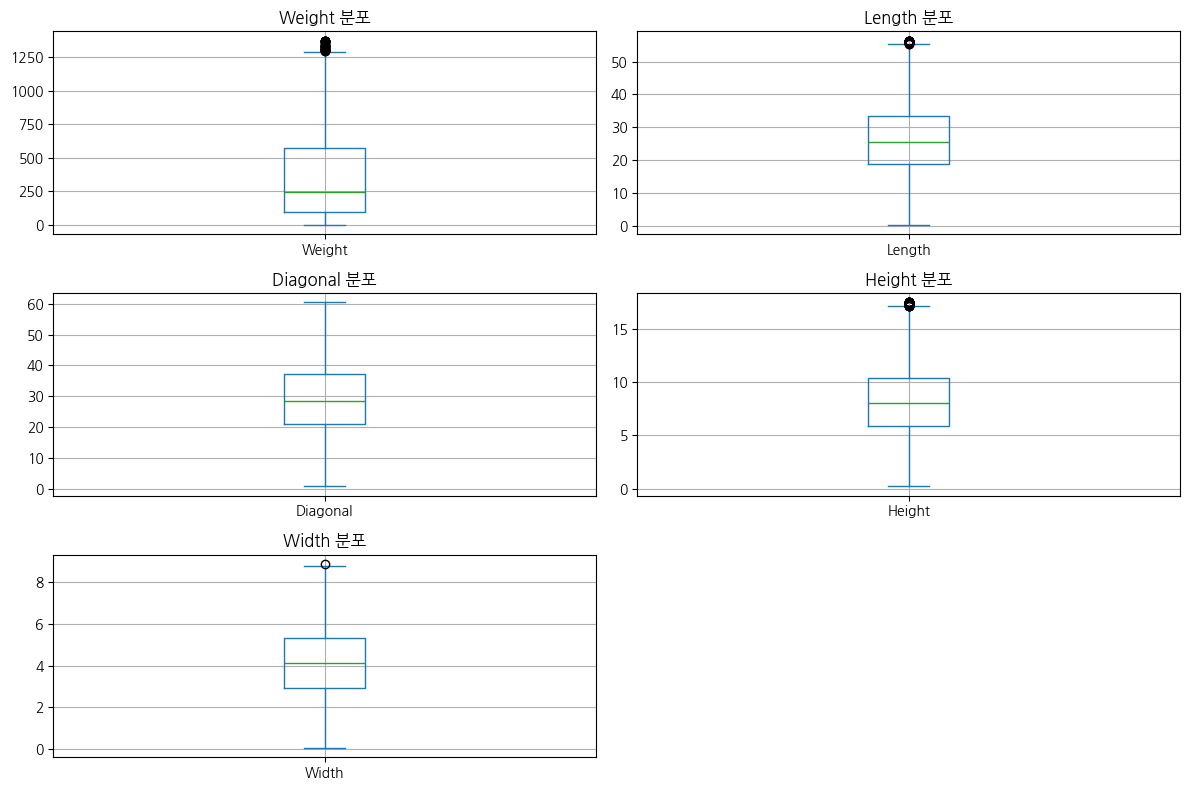

In [58]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

df[['Weight']].plot(kind='box', ax=axes[0, 0], grid=True)
axes[0, 0].set_title('Weight 분포')

df[['Length']].plot(kind='box', ax=axes[0, 1], grid=True)
axes[0, 1].set_title('Length 분포')

df[['Diagonal']].plot(kind='box', ax=axes[1, 0], grid=True)
axes[1, 0].set_title('Diagonal 분포')

df[['Height']].plot(kind='box', ax=axes[1, 1], grid=True)
axes[1, 1].set_title('Height 분포')

df[['Width']].plot(kind='box', ax=axes[2, 0], grid=True)
axes[2, 0].set_title('Width 분포')

axes[2, 1].set_visible(False)  # 마지막 칸 비우기

plt.tight_layout()
plt.show()

In [59]:
df.Species.value_counts()

Species
Roach        1500
Smelt        1500
Parkki       1500
Whitefish    1492
Perch        1485
Bream        1337
Pike         1279
Name: count, dtype: int64

In [ ]:
df.corr(numeric_only=True) ## 상관계수 Diagonal <-> Length (0.996290) 가장 높음

,Weight,Length,Diagonal,Height,Width
Weight,1.000000,0.890264,0.891605,0.678975,0.853543
Length,0.890264,1.000000,0.996290,0.637459,0.866834
Diagonal,0.891605,0.996290,1.000000,0.686460,0.877121
Height,0.678975,0.637459,0.686460,1.000000,0.818365
Width,0.853543,0.866834,0.877121,0.818365,1.000000


Text(0.5, 1.0, '대각선과 높이의 상관관계 산점도')

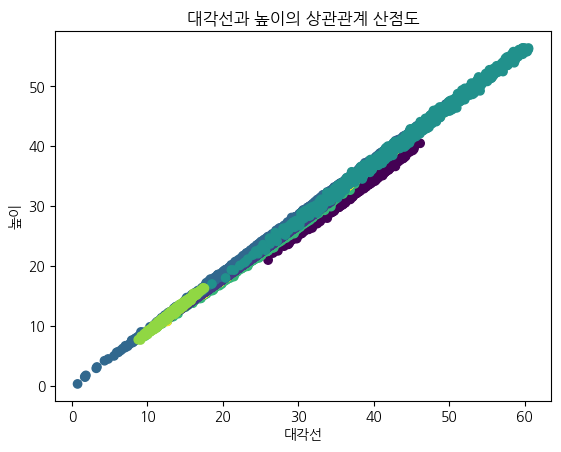

In [95]:
plt.scatter(df['Diagonal'], df['Length'], c=df['Species'].cat.codes)
plt.xlabel('대각선')
plt.ylabel('높이')
plt.title('대각선과 높이의 상관관계 산점도')

In [62]:
## [2-1] 품종컬럼 자료형 변환
pd.options.mode.copy_on_write = True

df.Species = df.Species.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10093 entries, 0 to 10499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Weight    10093 non-null  float64 
 1   Length    10093 non-null  float64 
 2   Diagonal  10093 non-null  float64 
 3   Height    10093 non-null  float64 
 4   Width     10093 non-null  float64 
 5   Species   10093 non-null  category
dtypes: category(1), float64(5)
memory usage: 483.3 KB


In [63]:
## [2-2] 피쳐와 타겟분리
featureDF = df[ df.columns[:-1] ]
targetSR  = df[ df.columns[-1]  ]

print(f'featureDF : {featureDF.shape},  targetSR : {targetSR.shape}')

featureDF : (10093, 5),  targetSR : (10093,)


In [64]:
## [2-3] 수치형 컬럼 => KNN 알고리즘 : 스케일링
stdScaler = StandardScaler()
stdScaler.fit(featureDF)

# 스케일링 진행
s_train = stdScaler.transform(featureDF)

[3] 교차검증 <hr>

In [74]:
## 모델 인스턴스 생성
columns_  = ['fit_time', 'score_time', 'test_score', 'train_score', 'neighbors']
resultDF  = pd.DataFrame( columns=columns_ )

for neighbors in range(1, 21):
    kModel = KNeighborsClassifier(n_neighbors=neighbors)

    ## 함수 호출
    resultDict = cross_validate( kModel,
                                 s_train,
                                 targetSR,
                                 return_train_score=True,
                                 cv=3)
    
    ret = [ resultDict[k].mean().item()  for k in resultDict.keys() ]
    ret.append(neighbors)
    resultDF.loc[resultDF.shape[0]] = ret

In [98]:
resultDF['diff'] = abs(resultDF['test_score'] - resultDF['train_score'])
resultDF.sort_values('diff')

,fit_time,score_time,test_score,train_score,neighbors,diff
18,0.006000,0.018001,0.934707,0.942633,19.0,0.007926
16,0.005616,0.017025,0.937184,0.945358,17.0,0.008174
13,0.005639,0.015030,0.944020,0.952343,14.0,0.008323
14,0.006428,0.015505,0.939661,0.948132,15.0,0.008471
19,0.005976,0.018506,0.934311,0.943079,20.0,0.008769
15,0.005632,0.016201,0.940156,0.949222,16.0,0.009066
17,0.006125,0.017339,0.936788,0.945903,18.0,0.009115
12,0.005360,0.014999,0.942633,0.951996,13.0,0.009363
9,0.006330,0.013003,0.949470,0.959824,10.0,0.010354
11,0.006003,0.014555,0.945804,0.956554,12.0,0.010750


[<Axes: > <Axes: >]


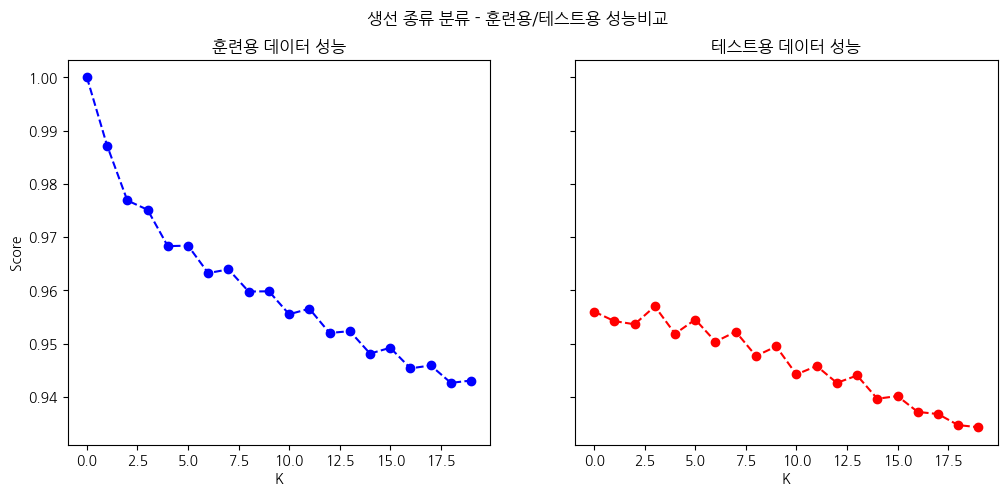

In [99]:
##- k 개수에 따른 학습 및 테스트 성능 시각화
fig, axes = plt.subplots(1,2, sharey=True, figsize=(12, 5))
print(axes)

axes[0].plot(resultDF['train_score'], 'bo--')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Score')
axes[0].set_title("훈련용 데이터 성능")

axes[1].plot(resultDF['test_score'], 'ro--')
axes[1].set_xlabel('K')
axes[1].set_title("테스트용 데이터 성능")

plt.suptitle('생선 종류 분류 - 훈련용/테스트용 성능비교')
plt.show()

[4] 학습 진행 <hr>

In [76]:
## [4-1] 모델 인스턴스 생성
kModel = KNeighborsClassifier(n_neighbors=15)
kModel

,n_neighbors,15
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [77]:
## [4-2] 학습 진행
kModel.fit(s_train, targetSR)

,n_neighbors,15
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


[5] 성능평가

In [78]:
train_score = kModel.score(s_train, targetSR)

print(f'학습 점수 : {train_score}')

학습 점수 : 0.9561081937976815


[6] 테스트 셋으로 확인하기 <hr>

In [79]:
## Test 데이터셋 불러오기
DATA_FILE_T = '../Data/fish_test_300.csv'

df_t = pd.read_csv(DATA_FILE_T)

In [80]:
df_t.Species = df_t.Species.astype('category')

tfeatureDF = df_t[ df.columns[:-1] ]
ttargetSR  = df_t[ df.columns[-1]  ]

print(f'tfeatureDF : {tfeatureDF.shape},  ttargetSR : {ttargetSR.shape}')

tfeatureDF : (300, 5),  ttargetSR : (300,)


In [81]:
## 스케일링 진행
s_test = stdScaler.transform(tfeatureDF)

In [82]:
test_score = kModel.score(s_test, ttargetSR)

print(f'테스트 점수 : {test_score}')

테스트 점수 : 0.9433333333333334


[7] 일반적인 데이터 예측 서비스 <hr>

In [102]:
## 아무 도미 또는 빙어의 길이/무게 ==> 도미와 빙어 예측
in_data = input("무게, 길이, 대각선, 높이, 너비 입력 (예: 200 25 30 10 5): ").strip().split()
in_data  = list(map(float, in_data))
print(f'new_data : {in_data}', end=' ')

## DF 형식으로 저장
new_data = pd.DataFrame([in_data] , columns=df.columns[:-1])

## 스케링일 진행
s_new_data = stdScaler.transform(new_data)
print(f'=> s_new_data : {s_new_data}' )

new_data : [200.08723400123714, 22.85612528882083, 25.650569289935405, 9.744760934742667, 3.719721357911858] => s_new_data : [[-0.47551793 -0.34624382 -0.31322312  0.41190204 -0.1844609 ]]


In [103]:
## 예측 진행
pre_target = kModel.predict(s_new_data)

print(f'무게 {in_data[0]:.2f}g, 길이 {in_data[1]:.2f}mm, 대각선 {in_data[2]:.2f}mm, 높이 {in_data[3]:.2f}mm, 너비 {in_data[4]:.2f}mm 생선은 {pre_target.item()}입니다.')

무게 200.09g, 길이 22.86mm, 대각선 25.65mm, 높이 9.74mm, 너비 3.72mm 생선은 Parkki입니다.


In [104]:
## proba 통한 예측 진행
proba_     = kModel.predict_proba(s_new_data)

print(f'proba => Bream : {proba_[0][0]*100}%, Roach : {proba_[0][1]*100}%, Whitefish : {proba_[0][2]*100}%, Parkki : {proba_[0][3]*100}%, Perch : {proba_[0][4]*100}%, Pike : {proba_[0][5]*100}%, Smelt : {proba_[0][6]*100}%')

proba => Bream : 0.0%, Roach : 100.0%, Whitefish : 0.0%, Parkki : 0.0%, Perch : 0.0%, Pike : 0.0%, Smelt : 0.0%


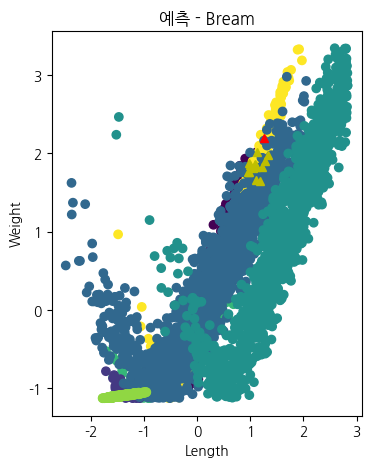

In [86]:
## 예측 검사
_, sIndices = kModel.kneighbors(s_new_data)

## 시각화 
plt.figure(figsize=(4, 5))
plt.scatter(s_train[:, 1], s_train[:, 0], c=targetSR.cat.codes)

#-> 새로운 데이터
plt.plot(s_new_data[0][1], s_new_data[0][0], '^r')

# #-> 이웃 데이터
nIdx = sIndices[0].tolist()
for idx in nIdx:
    plt.plot(s_train[idx][1], s_train[idx][0], '^y')

plt.xlabel('Length')
plt.ylabel('Weight')
plt.title(f'예측 - {pre_target.item()}')
plt.show()

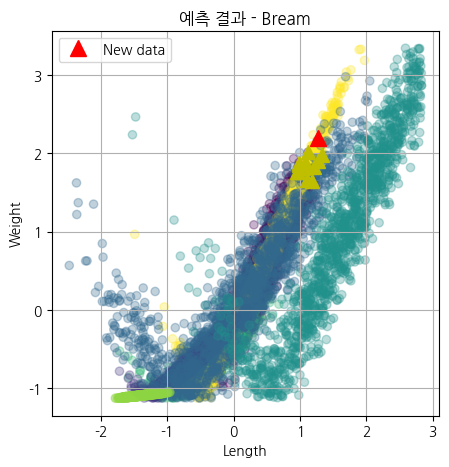

In [88]:
# 1) 컬럼 인덱스 찾기 (안전하게 이름으로)
x_name = 'Length'
y_name = 'Weight'

x_idx = df.columns.get_loc(x_name)   # Length의 열 인덱스
y_idx = df.columns.get_loc(y_name)   # Weight의 열 인덱스

# 2) KNN 이웃 인덱스
_, sIndices = kModel.kneighbors(s_new_data)
nIdx = sIndices[0].tolist()

# 3) 시각화
plt.figure(figsize=(5, 5))

# 전체 학습 데이터 (배경)
plt.scatter(
    s_train[:, x_idx],
    s_train[:, y_idx],
    c=targetSR.cat.codes,
    alpha=0.3
)

# 새 데이터 (빨간 삼각형)
plt.plot(
    s_new_data[0][x_idx],
    s_new_data[0][y_idx],
    '^r',
    markersize=12,
    label='New data'
)

# KNN 이웃들 (노란 삼각형)
for idx in nIdx:
    plt.plot(
        s_train[idx][x_idx],
        s_train[idx][y_idx],
        '^y',
        markersize=10
    )

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title(f'예측 결과 - {pre_target.item()}')
plt.legend()
plt.grid(True)
plt.show()


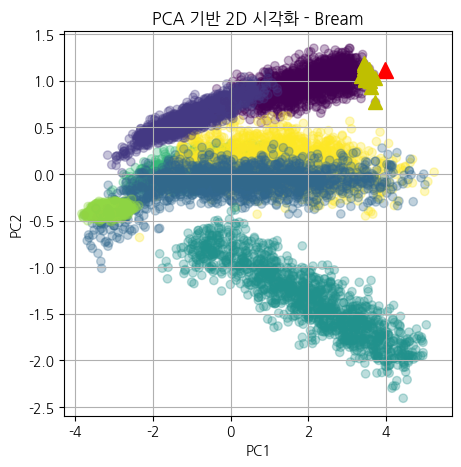

In [87]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
s_train_2d = pca.fit_transform(s_train)
s_new_2d   = pca.transform(s_new_data)

_, sIndices = kModel.kneighbors(s_new_data)
nIdx = sIndices[0].tolist()

plt.figure(figsize=(5,5))
plt.scatter(s_train_2d[:, 0], s_train_2d[:, 1], c=targetSR.cat.codes, alpha=0.3)
plt.plot(s_new_2d[0][0], s_new_2d[0][1], '^r', markersize=12)

for idx in nIdx:
    plt.plot(s_train_2d[idx][0], s_train_2d[idx][1], '^y', markersize=10)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'PCA 기반 2D 시각화 - {pre_target.item()}')
plt.grid(True)
plt.show()
